In [388]:
import sys
sys.path.append("../")

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *
from utils.utils import ring2nest

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [390]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Test embedding net

In [391]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [392]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.reorder(hp.ud_grade(hp_mask_nside1, nside), r2n=True)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

hp_mask_nside1 = hp.reorder(hp_mask_nside1, r2n=True)

In [393]:
hp_mask_nside1_ring = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0, mask_ring = True, inner = 0, outer = 25)
roi_sim_ring = hp.ud_grade(hp_mask_nside1_ring, 128)

In [394]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask = hp.reorder(hp_mask, r2n=True)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [395]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Test data generation

In [396]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [397]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [398]:
from simulations.wrapper import simulator

In [399]:
import sys
from sbi import utils
from sbi import inference

In [400]:
from utils.templates import get_NFW2_template

In [401]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")

fermi_exp_ring = np.load("../data/fermi_data/fermidata_exposure.npy")

# Rescaling factor to remove exposure from PS templates
rescale = fermi_exp_ring / np.mean(fermi_exp_ring)

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp_ring, roi_normalize=roi_normalize_temps)

# NEST ordering
fermi_exp = hp.reorder(np.load("../data/fermi_data/fermidata_exposure.npy"), r2n=True)

temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

# Load Model A templates
temp_mA_pibrem = hp.ud_grade(np.load('../data/external/template_Api.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/external/template_Aic.npy'), nside_out=128, power=-2)

# Load Model F templates
temp_mF_pibrem = hp.ud_grade(np.load('../data/external/template_Fpi.npy'), nside_out=128, power=-2)
temp_mF_ics = hp.ud_grade(np.load('../data/external/template_Fic.npy'), nside_out=128, power=-2)


ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
# ps_mask = np.load("../data/fermi_data/fermidata_pscmask.npy") > 0

roi_mask = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask), r2n=True)
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)

In [402]:
def get_signal_injection(coeff, plot_map=False, mask=hp_mask):
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce), r2n=True)
    in_map[mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

def get_signal_injection_ps(coeff, plot_map=False, mask=hp_mask, ps="medium"):
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy"), r2n=True)
    in_map[mask] = 0
    
    if ps == "bright":
        sb1 = 20.
    elif ps == "medium":
        sb1 = 10.
    elif ps == "dim":
        sb1 = 5.
    
    if coeff != 0.:
        
        prior_ps = [[0, coeff * 1., 20.0, 1.9, -10.0, sb1, 1.], [0, coeff * 1., 20.0, 1.9, -9.99, sb1, 1.]]
        prior_ps = utils.BoxUniform(low=torch.tensor(prior_ps[0]), high=torch.tensor(prior_ps[1]))
        theta = prior_ps.sample((1,))[0]
        temps_ps_sim = [temp_gce]
        temps_poiss_sim = [temp_gce]
        
        ps_map = simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, hp.reorder(masks_list[0], n2r=True)
                      , hp.reorder(roi_mask_norm, n2r=True), hp.reorder(roi_mask, n2r=True), pc_inst.psf_r_func, fermi_exp)[0]
        
        ps_map = ring2nest(ps_map, roi_sim_ring)
    
    else:
        ps_map = np.zeros((~masks_list[0]).sum())
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)
    
    in_map = in_map[~masks_list[0]]
    in_map += ps_map[0]
    
    in_map = torch.Tensor(in_map)
    
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

## SNPE


In [403]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, fc_dims=None).to(device)

In [404]:
sg_embed(get_signal_injection(0.).unsqueeze(0),).shape

torch.Size([1, 258])

In [405]:
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

In [406]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [407]:
from sbi import utils as utils

In [408]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 0.001], [1.5, 1.5, 1.5, 12., 6.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2.5, 20.0, 1.99, 1.99, 40.0, 4.99, 2.5, 20.0, 1.99, 1.99, 40.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device.type)

In [409]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [410]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics], r2n=True)
temps_ps = hp.reorder([temp_gce, temp_dsk], r2n=True)

temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce, temp_dsk]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [411]:
roi_normalize = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25), r2n=True)

In [412]:
from sbi.utils import x_shape_from_simulation

In [413]:
from utils.plotting import make_plot, make_signal_injection_plot
roi_sim = masks_list[0]

In [414]:
n_samples = 50000

# Thick disk

### Analysis on data

In [415]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = 'f0728b492c09438b9f0044b0e62ab189'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns//0/' + run_id + '/artifacts/density_estimator')

In [416]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection(coeff, mask=hp_mask).detach().numpy() for coeff in coeff_ary]))

data_map = x_test[:, 0, :-2]
aux = x_test[:, :, -2:]

In [417]:
temps_ps = hp.reorder([temp_gce / rescale, temp_dsk_thk / rescale], r2n=True)

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Removed no burn in
$7.9^{+0.2}_{-0.6}$ & $51.0^{+8.9}_{-21.7}$ & $1.4^{+0.2}_{-0.4}$ & $3.2^{+0.5}_{-1.2}$ & $2.5^{+0.3}_{-0.6}$


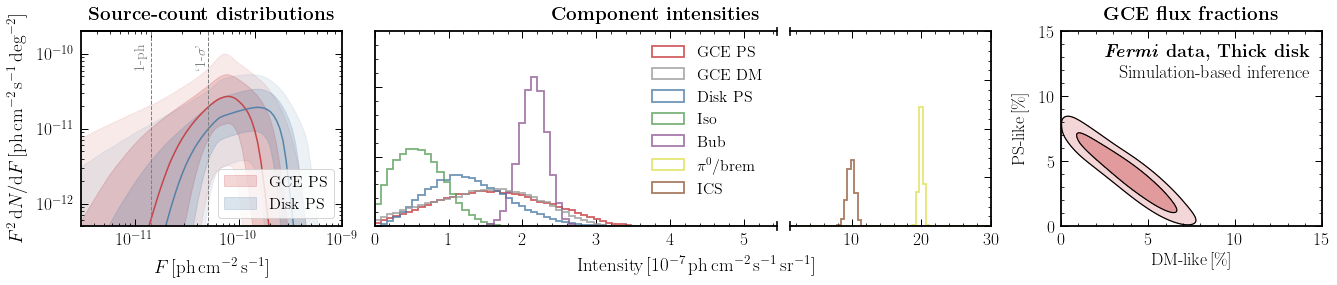

<Figure size 432x324 with 0 Axes>

In [418]:
x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)

posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, \
          roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=True, figsize=(24 / 1.3, 5 / 1.3), save_filename="../paper/plots/data_fid_sbi_thick.pdf", n_samples=n_samples, \
          temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Thick disk}", sub2=r"Simulation-based inference")

### NPTF analysis on data

Removed no burn in
$8.2^{+0.3}_{-0.7}$ & $75.0^{+7.1}_{-22.6}$ & $1.1^{+0.1}_{-0.2}$ & $2.3^{+0.7}_{-1.1}$ & $3.2^{+0.6}_{-1.2}$


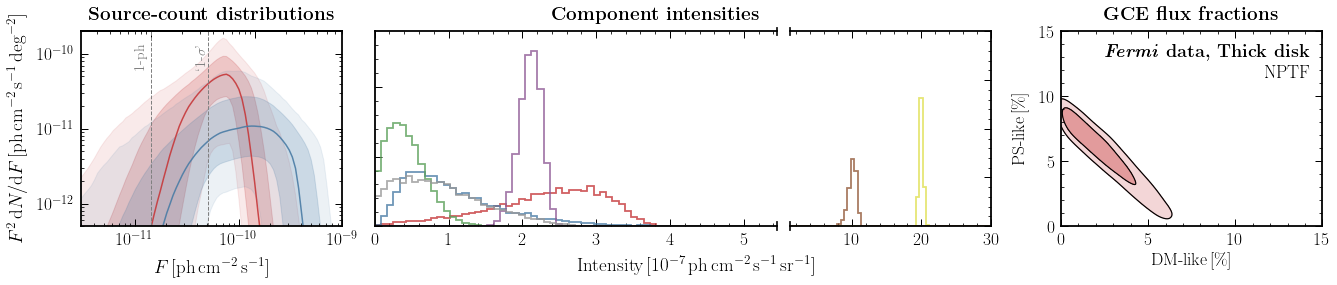

<Figure size 432x324 with 0 Axes>

In [419]:
coeff_ary = [0.]

samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_-1_samples_2.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=None, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, figsize=(24 / 1.3, 5 / 1.3), nptf=True, save_filename="../paper/plots/data_fid_nptf_thick.pdf", temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Thick disk}", sub2=r"NPTF", show_legend=False)




## Diffuse Model A

In [420]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics], r2n=True)
temps_ps = hp.reorder([temp_gce / rescale, temp_dsk / rescale], r2n=True)

temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [421]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '20004a61928e4711baf473e31213492b'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns//4/' + run_id + '/artifacts/density_estimator')

In [422]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection(coeff, mask=hp_mask).detach().numpy() for coeff in coeff_ary]))

data_map = x_test[:, 0, :-2]
aux = x_test[:, :, -2:]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Removed no burn in
$6.3^{+0.2}_{-0.6}$ & $47.2^{+10.5}_{-24.6}$ & $1.3^{+0.3}_{-0.4}$ & $4.9^{+0.5}_{-1.2}$ & $2.5^{+0.2}_{-0.5}$


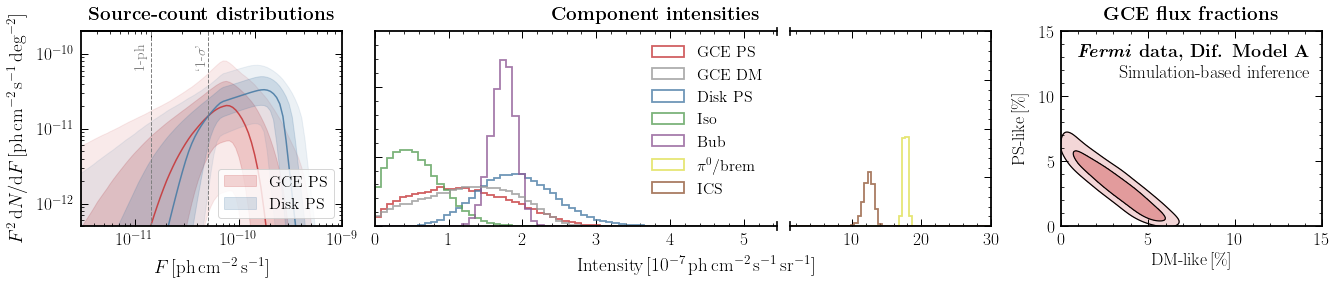

<Figure size 432x324 with 0 Axes>

In [423]:
x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)

posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, \
          signal_injection=True, figsize=(24 / 1.3, 5 / 1.3), save_filename="../paper/plots/data_fid_sbi_modelA.pdf", n_samples=n_samples, temps_dict=temps_dict,\
          sub1=r"\bf{\emph{Fermi} data, Dif. Model A}",sub2=r"Simulation-based inference")

Removed no burn in
$6.7^{+0.2}_{-0.6}$ & $74.9^{+6.6}_{-22.5}$ & $1.1^{+0.1}_{-0.2}$ & $5.1^{+0.5}_{-1.3}$ & $2.2^{+0.2}_{-0.5}$


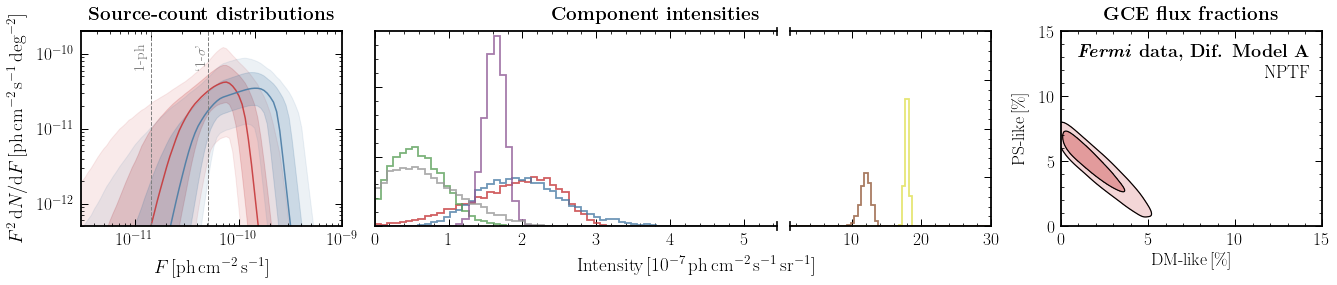

<Figure size 432x324 with 0 Axes>

In [424]:
coeff_ary = [0.]

samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_thin_disk_ModelA_1000_-1_samples.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, \
          theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, \
          figsize=(24 / 1.3, 5 / 1.3), nptf=True, save_filename="../paper/plots/data_fid_nptf_modelA.pdf", temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Dif. Model A}",sub2=r"NPTF", show_legend=False)

## Diffuse Model F

In [425]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mF_pibrem, temp_mF_ics], r2n=True)
temps_ps = hp.reorder([temp_gce / rescale, temp_dsk / rescale], r2n=True)

temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [426]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '6576ffd356194558b08fe706e8d17865'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns//6/' + run_id + '/artifacts/density_estimator')

In [427]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection(coeff, mask=hp_mask).detach().numpy() for coeff in coeff_ary]))

data_map = x_test[:, 0, :-2]
aux = x_test[:, :, -2:]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Removed no burn in
$4.7^{+0.2}_{-0.6}$ & $62.5^{+10.1}_{-26.9}$ & $1.5^{+0.3}_{-0.5}$ & $5.2^{+0.4}_{-1.1}$ & $2.5^{+0.2}_{-0.5}$


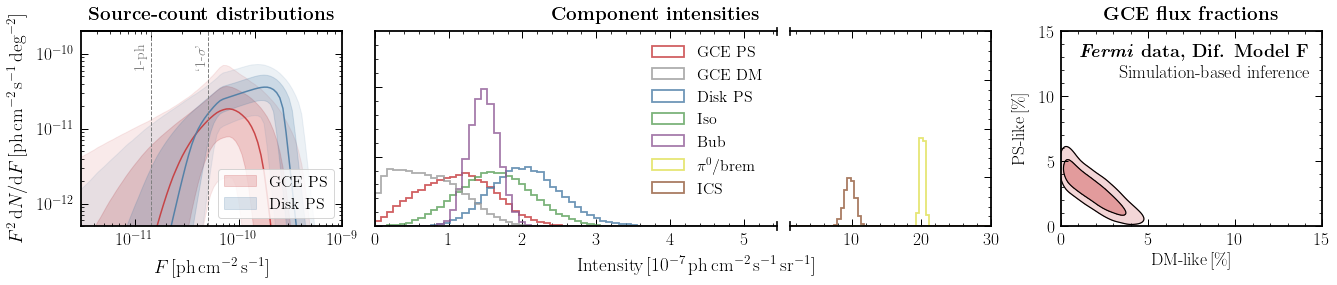

<Figure size 432x324 with 0 Axes>

In [428]:
x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)

posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, \
          signal_injection=True, figsize=(24 / 1.3, 5 / 1.3), save_filename="../paper/plots/data_fid_sbi_modelF.pdf", n_samples=n_samples, temps_dict=temps_dict,\
          sub1=r"\bf{\emph{Fermi} data, Dif. Model F}",sub2=r"Simulation-based inference")

Removed no burn in
$5.2^{+0.2}_{-0.5}$ & $67.5^{+8.6}_{-26.7}$ & $1.1^{+0.2}_{-0.3}$ & $6.4^{+0.5}_{-1.1}$ & $2.0^{+0.2}_{-0.4}$


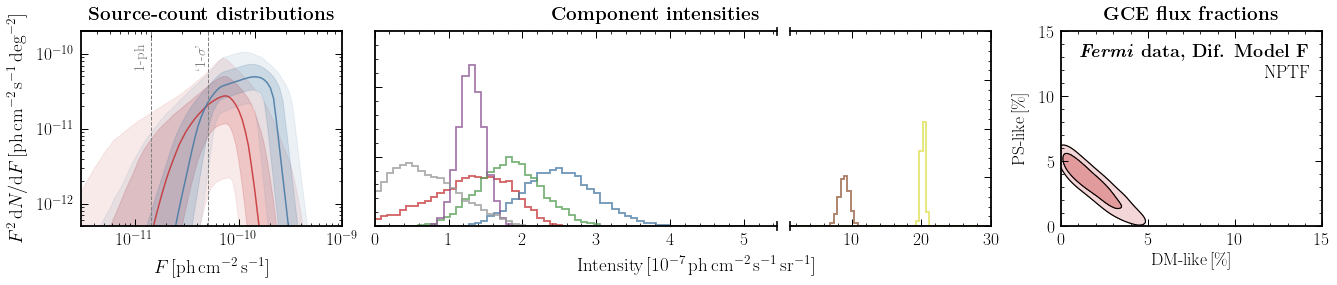

<Figure size 432x324 with 0 Axes>

In [429]:
coeff_ary = [0.]

samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_thin_disk_ModelF_1000_-1_samples.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, \
          theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, \
          figsize=(24 / 1.3, 5 / 1.3), nptf=True, save_filename="../paper/plots/data_fid_nptf_modelF.pdf", temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Dif. Model F}",sub2=r"NPTF", show_legend=False)

## PS prior going down to smaller counts

In [430]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 0.001], [1.5, 1.5, 1.5, 12., 6.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 1.0, 0.1, 0.001, 10.0, 1.1, -10.0, 1.0, 0.1], 
            [2.5, 20.0, 1.99, 1.99, 30.0, 4.99, 2.5, 20.0, 1.99, 1.99, 30.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device.type)

In [431]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics], r2n=True)
temps_ps = hp.reorder([temp_gce / rescale, temp_dsk / rescale], r2n=True)

temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [432]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '968012bcc62e4580912a7a2cfbd73d02'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns//13/' + run_id + '/artifacts/density_estimator')

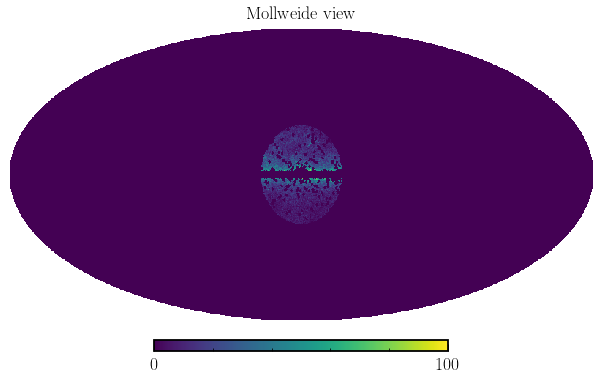

In [433]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection(coeff, mask=hp_mask, plot_map=True).detach().numpy() for coeff in coeff_ary]))

data_map = x_test[:, 0, :-2]
aux = x_test[:, :, -2:]

In [434]:
n_samples = 50000

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Removed no burn in
$7.7^{+0.2}_{-0.6}$ & $54.2^{+11.9}_{-27.4}$ & $0.9^{+0.2}_{-0.4}$ & $5.9^{+0.5}_{-1.1}$ & $2.4^{+0.2}_{-0.4}$


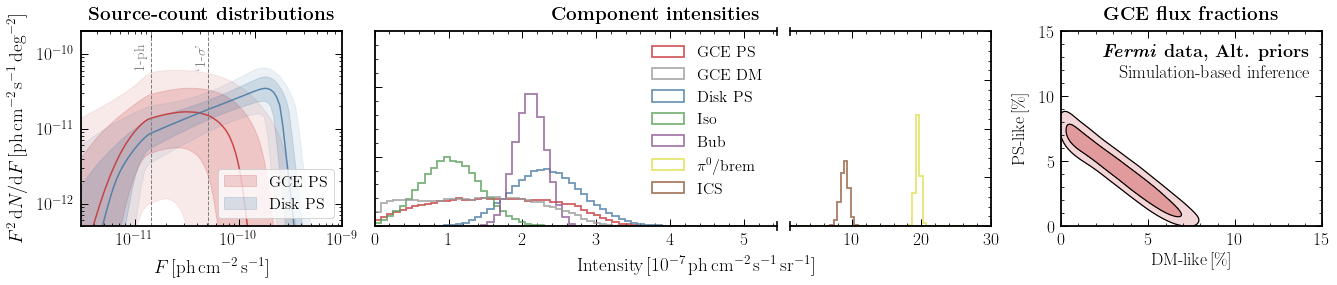

<Figure size 432x324 with 0 Axes>

In [435]:
x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)

posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, \
          signal_injection=True, figsize=(24 / 1.3, 5 / 1.3), save_filename="../paper/plots/data_fid_sbi_new_ps_priors.pdf", n_samples=n_samples, temps_dict=temps_dict,\
          sub1=r"\bf{\emph{Fermi} data, Alt. priors}",sub2=r"Simulation-based inference")

In [346]:
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

In [247]:
def get_unc(post):
    return ufloat(np.mean(post), np.std(post))

In [248]:
get_unc(post_alt['integ_below']) - get_unc(post_fid['integ_below'])

0.29247477731927135+/-0.4542948838259376

In [249]:
np.mean(post_fid['integ_below']), np.mean(post_alt['integ_below'])

(0.33069742869890023, 0.6231722060181716)

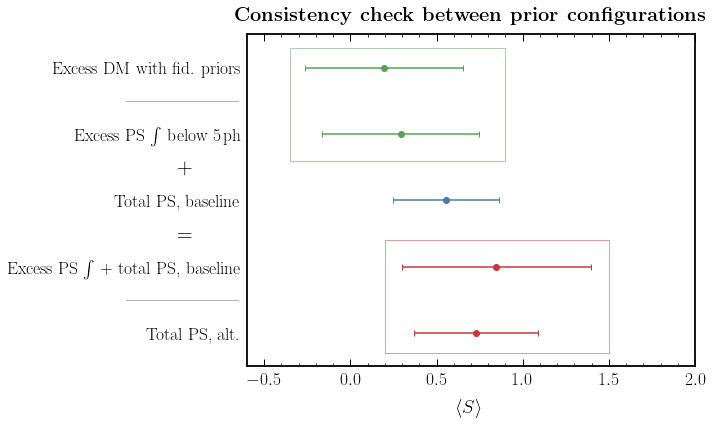

In [474]:
post_fid = np.load("/Users/smsharma/Desktop/post_fid.npz")
post_alt = np.load("/Users/smsharma/Desktop/post_alt.npz")

xtra_below = get_unc(post_alt['integ_below']) - get_unc(post_fid['integ_below'])
xtra_dm = get_unc(post_fid['post_dm']) - get_unc(post_alt['post_dm'])

fid_tot = get_unc(post_fid['post_tot'])
summed = ((xtra_below) + (fid_tot))

alt_tot = get_unc(post_alt['post_tot'])

plt.figure(figsize = (10, 6))

x_list=[0, 1, 2, 3, 4]
y_list=[alt_tot.n, summed.n, fid_tot.n, xtra_below.n, xtra_dm.n]#[::-1]
yerr_list=[alt_tot.std_dev, summed.std_dev, fid_tot.std_dev, xtra_below.std_dev, xtra_dm.std_dev]#[::-1]
cols_list = [cols_default[0], cols_default[0], cols_default[1], cols_default[2], cols_default[2]]

for x, y, yerr, col in zip(x_list, y_list, yerr_list, cols_list):
    plt.errorbar(x=y, 
                 y=x, 
                 xerr=yerr,
                 color=col,
                 fmt='o', capsize=3, capthick=1, elinewidth=1.5)

plt.text(-1., 1.4, r"$=$", fontsize=22)
plt.text(-1., 2.4, r"$+$", fontsize=22)

plt.yticks(np.arange(5), 
           labels=["Excess DM with fid. priors", r"Excess PS $\int$ below 5\,ph", "Total PS, baseline", "Excess PS $\int$ + total PS, baseline", "Total PS, alt."][::-1],
           rotation=0)

plt.tick_params(axis = "y", which = "both", left = False, right = False)

from matplotlib import lines

y,x = np.array([[.5, .5], [-0.65, -1.3]],)
line = lines.Line2D(x, y, color='grey', lw=1, alpha=0.6,)
ax = plt.gca()
ax.add_line(line)
line.set_clip_on(False)

y,x = np.array([[3.5, 3.5], [-0.65, -1.3]],)
line = lines.Line2D(x, y, color='grey', lw=1, alpha=0.6,)
ax.add_line(line)
line.set_clip_on(False)

# Create a Rectangle patch
from matplotlib.patches import Rectangle

rect = Rectangle((0.2, -0.3) , 1.3, 1.7, linewidth=1, edgecolor=cols_default[0], lw=0.5, facecolor='none')
ax.add_patch(rect)

rect = Rectangle((-0.35, 2.6) , 1.25, 1.7, linewidth=1, edgecolor=cols_default[2], lw=0.5, facecolor='none')
ax.add_patch(rect)

plt.xlabel(r"$\langle S \rangle$")
plt.xlim(-0.6, 2)
plt.ylim(-0.5, 4.5)

plt.title(r"\bf{Consistency check between prior configurations}", y=1.02, fontsize=20.3)

plt.tight_layout()
plt.savefig("../paper/plots/consistency_check.pdf")

In [201]:
data_samples = posterior.sample(sample_shape=(20000,), x=x_test)

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

In [202]:
from getdist import plots, MCSamples

ndim = 6
samps = data_samples.detach().numpy()[:,-6:]

Removed no burn in


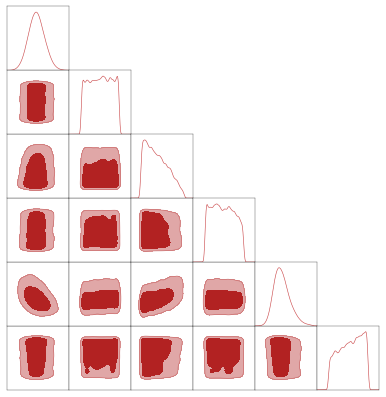

In [203]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
names = ["x%s"%i for i in range(ndim)]
labels =  ["x_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)

# Triangle plot

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0.3 #set the value globally

g = plots.get_subplot_plotter(subplot_size=1, scaling=True)
g.settings.axes_fontsize=0
g.triangle_plot([samples], filled=True,line_args=[{'ls':'-', 'color':cols_default[0]},], 
    contour_colors=['firebrick'],
)

for i in range(6):
    for j in range(6):
        if g.subplots[i,j] is not None:
            g.subplots[i,j].set_xticks([], [])
            g.subplots[i,j].set_yticks([], [])
            g.subplots[i,j].set_xlabel(None)
            g.subplots[i,j].set_ylabel(None)
            
plt.savefig("/Users/smsharma/Desktop/post.pdf")

In [70]:
np.percentile(data_samples.detach().numpy()[:, 10], [16,50,84])

array([ 3.14745405,  6.28604031, 11.76935154])

Removed no burn in
$7.9^{+0.2}_{-0.6}$ & $77.7^{+6.5}_{-21.4}$ & $0.9^{+0.1}_{-0.3}$ & $5.9^{+0.5}_{-1.1}$ & $2.3^{+0.2}_{-0.4}$


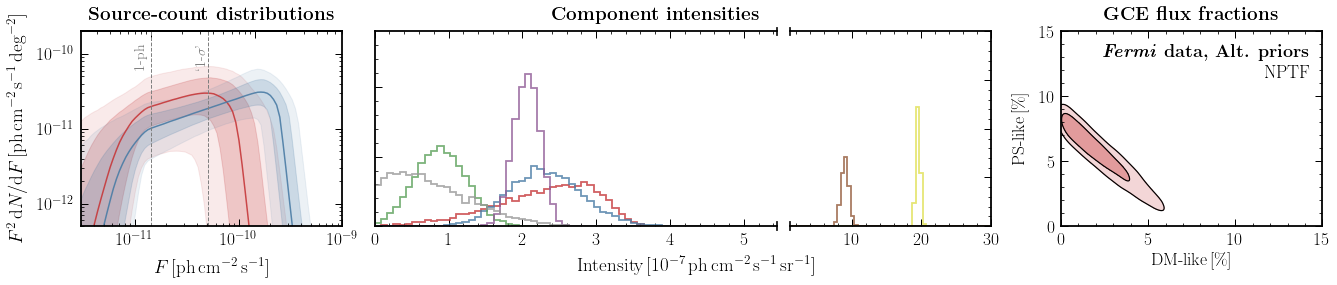

<Figure size 432x324 with 0 Axes>

In [436]:
coeff_ary = [0.]

samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_thin_disk_new_ps_priors_1000_-1_samples.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, \
          theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, \
          figsize=(24 / 1.3, 5 / 1.3), nptf=True, save_filename="../paper/plots/data_fid_nptf_new_ps_priors.pdf", temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Alt. priors}",sub2=r"NPTF", show_legend=False)